# Import Price Data From Kraken API:

In [226]:
import krakenex 
from pykrakenapi import KrakenAPI
import sys
import time
import urllib.request
import json
import requests
import pandas as pd
import numpy as np 

import hvplot
import hvplot.pandas
from IPython.display import Markdown

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

from joblib import dump, load

pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.width", 1000)

import warnings
warnings.filterwarnings('ignore')

In [227]:
api = krakenex.API()
k = KrakenAPI(api)

In [228]:
ohlc = k.get_ohlc_data("BTCUSD")

In [229]:
def fetch_OHLC_data(symbol, timeframe):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'
    response = requests.get(url)
    if response.status_code == 200: 
        j = json.loads(response.text)
        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])
        else:
            data = pd.DataFrame(result[keys[1]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])

        data['date'] = pd.to_datetime(data['unix'], unit='s')
        data['volume_from'] = data['volume'].astype(float) * data['close'].astype(float)
    return data

In [230]:
btc = fetch_OHLC_data(symbol="BTC/USD", timeframe="1440")
btc = btc.drop(columns=["unix", "open", "high", "low", "volume_from"])
btc = btc.set_index("date")
btc['close'] = btc['close'].astype(float)
btc['returns'] = btc.close.pct_change()
btc['change_in_price'] = btc['returns']
btc.change_in_price[btc.change_in_price > 0] = 1
btc.change_in_price[btc.change_in_price <= 0] = 0
btc.dropna(inplace=True)
btc['change_in_price'] = btc['change_in_price'].astype(int)
btc.head()

,close,vwap,volume,tradecount,returns,change_in_price
date,,,,,,
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1
2019-06-26,12933.7,12684.3,25637.82859518,100171,0.099328,1
2019-06-27,11148.0,11581.1,25035.66966057,90274,-0.138066,0


# Generate Quantitative Trading Signals:

In [231]:
def generate_signals(btc):
    """Generates trading signals for a given dataset."""
    # Grab just the `date` and `close` from the IEX dataset
    signals_df = btc.copy()
    # Set the short window and long windows
    short_window = 50
    long_window = 100

    # Generate the short and long moving averages (50 and 100 days, respectively)
    signals_df["SMA50"] = signals_df["close"].rolling(window=short_window).mean()
    signals_df["SMA100"] = signals_df["close"].rolling(window=long_window).mean()

    signals_df["Signal"] = 0.0
    # Generate the trading signal 0 or 1,
    # where 0 is when the SMA50 is under the SMA100, and
    # where 1 is when the SMA50 is higher (or crosses over) the SMA100
    signals_df["Signal"][short_window:] = np.where(
        signals_df["SMA50"][short_window:] > signals_df["SMA100"][short_window:],
        1.0,
        0.0,
    )
    # Calculate the points in time at which a position should be taken, 1 or -1
    signals_df["Entry/Exit"] = signals_df["Signal"].diff()
    return signals_df

In [232]:
mov_avg = generate_signals(btc)
mov_avg.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit
date,,,,,,,,,,
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0
2021-06-07,33587.6,35319.4,6165.92045486,42615,-0.061511,0,46775.562,51538.067,0.0,0.0
2021-06-08,33420.0,32712.0,10548.32694320,72896,-0.004990,0,46329.562,51419.813,0.0,0.0
2021-06-09,37396.4,34956.4,9357.47210920,65863,0.118983,1,45947.490,51297.570,0.0,0.0
2021-06-10,37140.1,37215.2,280.35002083,2167,-0.006854,0,45613.988,51184.109,0.0,0.0


In [233]:
bollinger_window = 20

# Calculate rolling mean and standard deviation
all_sig = mov_avg.copy()
all_sig['bollinger_mid_band'] = mov_avg['close'].rolling(window=bollinger_window).mean()
all_sig['bollinger_std'] = mov_avg['close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
all_sig['bollinger_upper_band']  = all_sig['bollinger_mid_band'] + (all_sig['bollinger_std'] * 1)
all_sig['bollinger_lower_band']  = all_sig['bollinger_mid_band'] - (all_sig['bollinger_std'] * 1)

# Calculate bollinger band trading signal
all_sig['bollinger_long'] = np.where(all_sig['close'] < all_sig['bollinger_lower_band'], 1.0, 0.0)
all_sig['bollinger_short'] = np.where(all_sig['close'] > all_sig['bollinger_upper_band'], -1.0, 0.0)
all_sig['bollinger_signal'] = all_sig['bollinger_long'] + all_sig['bollinger_short']
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
date,,,,,,,,,,,,,,,,,
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0,37484.035,2047.953661,39531.988661,35436.081339,0.0,0.0,0.0
2021-06-07,33587.6,35319.4,6165.92045486,42615,-0.061511,0,46775.562,51538.067,0.0,0.0,37018.655,1795.580802,38814.235802,35223.074198,1.0,0.0,1.0
2021-06-08,33420.0,32712.0,10548.32694320,72896,-0.004990,0,46329.562,51419.813,0.0,0.0,36852.540,1967.902434,38820.442434,34884.637566,1.0,0.0,1.0
2021-06-09,37396.4,34956.4,9357.47210920,65863,0.118983,1,45947.490,51297.570,0.0,0.0,36691.630,1765.234552,38456.864552,34926.395448,0.0,0.0,0.0
2021-06-10,37140.1,37215.2,280.35002083,2167,-0.006854,0,45613.988,51184.109,0.0,0.0,36682.050,1762.095159,38444.145159,34919.954841,0.0,0.0,0.0


In [234]:
from ta.momentum import RSIIndicator

In [235]:
rsi_14 = RSIIndicator(close = all_sig.close, window = 14)
all_sig["RSI"] = rsi_14.rsi()
all_sig["RSI_long"] = np.where(all_sig["RSI"] < 30, 1.0, 0.0)
all_sig["RSI_short"] = np.where(all_sig["RSI"] > 70, -1.0, 0.0)
all_sig["RSI_signal"] = all_sig["RSI_long"] + all_sig["RSI_short"]
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal
date,,,,,,,,,,,,,,,,,,,,,
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0,37484.035,2047.953661,39531.988661,35436.081339,0.0,0.0,0.0,38.258192,0.0,0.0,0.0
2021-06-07,33587.6,35319.4,6165.92045486,42615,-0.061511,0,46775.562,51538.067,0.0,0.0,37018.655,1795.580802,38814.235802,35223.074198,1.0,0.0,1.0,34.667528,0.0,0.0,0.0
2021-06-08,33420.0,32712.0,10548.32694320,72896,-0.004990,0,46329.562,51419.813,0.0,0.0,36852.540,1967.902434,38820.442434,34884.637566,1.0,0.0,1.0,34.402798,0.0,0.0,0.0
2021-06-09,37396.4,34956.4,9357.47210920,65863,0.118983,1,45947.490,51297.570,0.0,0.0,36691.630,1765.234552,38456.864552,34926.395448,0.0,0.0,0.0,45.112041,0.0,0.0,0.0
2021-06-10,37140.1,37215.2,280.35002083,2167,-0.006854,0,45613.988,51184.109,0.0,0.0,36682.050,1762.095159,38444.145159,34919.954841,0.0,0.0,0.0,44.606547,0.0,0.0,0.0


In [236]:
all_sig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719 entries, 2019-06-23 to 2021-06-10
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   close                 719 non-null    float64
 1   vwap                  719 non-null    object 
 2   volume                719 non-null    object 
 3   tradecount            719 non-null    int64  
 4   returns               719 non-null    float64
 5   change_in_price       719 non-null    int64  
 6   SMA50                 670 non-null    float64
 7   SMA100                620 non-null    float64
 8   Signal                719 non-null    float64
 9   Entry/Exit            718 non-null    float64
 10  bollinger_mid_band    700 non-null    float64
 11  bollinger_std         700 non-null    float64
 12  bollinger_upper_band  700 non-null    float64
 13  bollinger_lower_band  700 non-null    float64
 14  bollinger_long        719 non-null    float64
 15  boll

In [237]:
all_sig['vwap'] = all_sig['vwap'].astype(float)
all_sig['volume'] = all_sig['volume'].astype(float)
# Generate the trading signal 0 or 1,
# where 0 is when the close is under the VWAP, and
# where 1 is when the close is higher (or crosses over) the VWAP
# all_sig["VWAP_long"] = np.where(all_sig["close"] < all_sig["vwap"], 0)
# all_sig["VWAP_short"] = np.where(all_sig["close"] > all_sig["vwap"], 1)
# all_sig["VWAP_signal"] = all_sig["VWAP_short"] + all_sig["VWAP_long"]
all_sig["VWAP_signal"] = np.where(all_sig["close"] < all_sig["vwap"], 0,1)
all_sig['VWAP_signal'] = all_sig['VWAP_signal'].astype(float)
all_sig.tail()


,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,
2021-06-06,35789.0,35930.0,3187.546401,23692,0.007159,1,47228.606,51663.893,0.0,0.0,37484.035,2047.953661,39531.988661,35436.081339,0.0,0.0,0.0,38.258192,0.0,0.0,0.0,0.0
2021-06-07,33587.6,35319.4,6165.920455,42615,-0.061511,0,46775.562,51538.067,0.0,0.0,37018.655,1795.580802,38814.235802,35223.074198,1.0,0.0,1.0,34.667528,0.0,0.0,0.0,0.0
2021-06-08,33420.0,32712.0,10548.326943,72896,-0.004990,0,46329.562,51419.813,0.0,0.0,36852.540,1967.902434,38820.442434,34884.637566,1.0,0.0,1.0,34.402798,0.0,0.0,0.0,1.0
2021-06-09,37396.4,34956.4,9357.472109,65863,0.118983,1,45947.490,51297.570,0.0,0.0,36691.630,1765.234552,38456.864552,34926.395448,0.0,0.0,0.0,45.112041,0.0,0.0,0.0,1.0
2021-06-10,37140.1,37215.2,280.350021,2167,-0.006854,0,45613.988,51184.109,0.0,0.0,36682.050,1762.095159,38444.145159,34919.954841,0.0,0.0,0.0,44.606547,0.0,0.0,0.0,0.0


# Random Forest With Raw Variables

In [238]:
X = all_sig.copy()
X.dropna(inplace=True)
X.drop(columns=['close','returns','change_in_price'], inplace=True)
X.head()

,vwap,volume,tradecount,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_signal
date,,,,,,,,,,,,,,,,,,,
2019-09-30,8051.4,7532.446692,29502,9974.046,10466.855,0.0,0.0,9508.810,959.804138,10468.614138,8549.005862,1.0,0.0,1.0,29.517131,1.0,0.0,1.0,1.0
2019-10-01,8379.4,7856.250205,31716,9912.822,10441.944,0.0,0.0,9416.925,981.823851,10398.748851,8435.101149,1.0,0.0,1.0,29.855162,1.0,0.0,1.0,0.0
2019-10-02,8262.6,3884.724758,12206,9863.328,10415.561,0.0,0.0,9315.040,977.974862,10293.014862,8337.065138,0.0,0.0,0.0,31.469716,0.0,0.0,0.0,1.0
2019-10-03,8206.0,5110.216416,14991,9827.730,10380.291,0.0,0.0,9208.840,973.603132,10182.443132,8235.236868,0.0,0.0,0.0,29.680654,1.0,0.0,1.0,1.0
2019-10-04,8148.2,3962.292889,10426,9784.684,10332.476,0.0,0.0,9098.290,961.075963,10059.365963,8137.214037,0.0,0.0,0.0,28.636266,1.0,0.0,1.0,1.0


In [239]:
y=all_sig['change_in_price'].values.reshape(-1,1)
y=y[99:]
y[:5]

array([[1],
       [1],
       [1],
       [0],
       [0]])

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [241]:
scaler = StandardScaler()

In [242]:
X_scaler = scaler.fit(X_train)

In [243]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [244]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [245]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [246]:
predictions = rf_model.predict(X_test_scaled)

In [247]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

acc_score = accuracy_score(y_test, predictions)

In [248]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,52,23
Actual 1,26,54


Accuracy Score : 0.6838709677419355
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        75
           1       0.70      0.68      0.69        80

    accuracy                           0.68       155
   macro avg       0.68      0.68      0.68       155
weighted avg       0.68      0.68      0.68       155



In [249]:
importances = rf_model.feature_importances_

In [250]:
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.23948493182776312, 'VWAP_signal'),
 (0.09540017576571523, 'RSI'),
 (0.08304880959989008, 'volume'),
 (0.06914451568438272, 'tradecount'),
 (0.06861993464094678, 'vwap'),
 (0.06449404033150617, 'bollinger_upper_band'),
 (0.062045223668699974, 'bollinger_std'),
 (0.06090549257323458, 'SMA50'),
 (0.06066600559660329, 'SMA100'),
 (0.06030253973477976, 'bollinger_lower_band')]

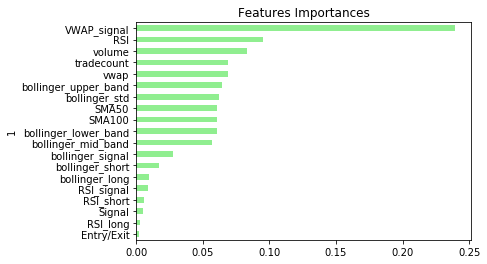

In [251]:
importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances.set_index(importances[1], inplace=True)
importances.drop(columns=1, inplace=True)
importances.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Random Forest on Signals: 

In [252]:
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,
2021-06-06,35789.0,35930.0,3187.546401,23692,0.007159,1,47228.606,51663.893,0.0,0.0,37484.035,2047.953661,39531.988661,35436.081339,0.0,0.0,0.0,38.258192,0.0,0.0,0.0,0.0
2021-06-07,33587.6,35319.4,6165.920455,42615,-0.061511,0,46775.562,51538.067,0.0,0.0,37018.655,1795.580802,38814.235802,35223.074198,1.0,0.0,1.0,34.667528,0.0,0.0,0.0,0.0
2021-06-08,33420.0,32712.0,10548.326943,72896,-0.004990,0,46329.562,51419.813,0.0,0.0,36852.540,1967.902434,38820.442434,34884.637566,1.0,0.0,1.0,34.402798,0.0,0.0,0.0,1.0
2021-06-09,37396.4,34956.4,9357.472109,65863,0.118983,1,45947.490,51297.570,0.0,0.0,36691.630,1765.234552,38456.864552,34926.395448,0.0,0.0,0.0,45.112041,0.0,0.0,0.0,1.0
2021-06-10,37140.1,37215.2,280.350021,2167,-0.006854,0,45613.988,51184.109,0.0,0.0,36682.050,1762.095159,38444.145159,34919.954841,0.0,0.0,0.0,44.606547,0.0,0.0,0.0,0.0


In [253]:
x_var_list = ['Signal', 'bollinger_signal', 'RSI_signal', 'VWAP_signal']
all_sig[x_var_list].tail()

#x_var_list = ['Signal', 'Entry/Exit', 'bollinger_long', 'bollinger_short', 'RSI_long', 'RSI_short', 'RSI_signal', 'VWAP_signal']
#all_sig[x_var_list].tail()


,Signal,bollinger_signal,RSI_signal,VWAP_signal
date,,,,
2021-06-06,0.0,0.0,0.0,0.0
2021-06-07,0.0,1.0,0.0,0.0
2021-06-08,0.0,1.0,0.0,1.0
2021-06-09,0.0,0.0,0.0,1.0
2021-06-10,0.0,0.0,0.0,0.0


In [254]:
all_sig.dropna(subset=x_var_list, inplace=True)
all_sig.dropna(subset=['returns'],inplace=True)
all_sig = all_sig.replace([np.inf, -np.inf], np.nan)
all_sig.head()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_signal
date,,,,,,,,,,,,,,,,,,,,,,
2019-06-23,10814.1,10837.5,5943.468917,34849,0.014094,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2019-06-24,11020.6,10843.5,5457.412726,26308,0.019095,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0
2019-06-25,11765.1,11340.2,11623.881444,40223,0.067555,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0
2019-06-26,12933.7,12684.3,25637.828595,100171,0.099328,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0
2019-06-27,11148.0,11581.1,25035.669661,90274,-0.138066,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [255]:
all_sig['Positive Return'] = np.where(all_sig['returns'] > 0, 1.0, 0.0)
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_signal,Positive Return
date,,,,,,,,,,,,,,,,,,,,,,,
2021-06-06,35789.0,35930.0,3187.546401,23692,0.007159,1,47228.606,51663.893,0.0,0.0,37484.035,2047.953661,39531.988661,35436.081339,0.0,0.0,0.0,38.258192,0.0,0.0,0.0,0.0,1.0
2021-06-07,33587.6,35319.4,6165.920455,42615,-0.061511,0,46775.562,51538.067,0.0,0.0,37018.655,1795.580802,38814.235802,35223.074198,1.0,0.0,1.0,34.667528,0.0,0.0,0.0,0.0,0.0
2021-06-08,33420.0,32712.0,10548.326943,72896,-0.004990,0,46329.562,51419.813,0.0,0.0,36852.540,1967.902434,38820.442434,34884.637566,1.0,0.0,1.0,34.402798,0.0,0.0,0.0,1.0,0.0
2021-06-09,37396.4,34956.4,9357.472109,65863,0.118983,1,45947.490,51297.570,0.0,0.0,36691.630,1765.234552,38456.864552,34926.395448,0.0,0.0,0.0,45.112041,0.0,0.0,0.0,1.0,1.0
2021-06-10,37140.1,37215.2,280.350021,2167,-0.006854,0,45613.988,51184.109,0.0,0.0,36682.050,1762.095159,38444.145159,34919.954841,0.0,0.0,0.0,44.606547,0.0,0.0,0.0,0.0,0.0


In [256]:
training_start = all_sig.index.min().strftime(format='%Y-%m-%d')
training_end = '2019-12-31'
testing_start = '2019-06-21'
testing_end = all_sig.index.max().strftime(format='%Y-%m-%d')
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-06-23
Training End: 2019-12-31
Testing Start: 2019-06-21
Testing End: 2021-06-10


In [257]:
# Construct the X_train and y_train datasets
X_train = all_sig[x_var_list][training_start:training_end]
y_train = all_sig['Positive Return'][training_start:training_end]

X_train.tail()

,Signal,bollinger_signal,RSI_signal,VWAP_signal
date,,,,
2019-12-27,0.0,0.0,0.0,1.0
2019-12-28,0.0,0.0,0.0,0.0
2019-12-29,0.0,-1.0,0.0,0.0
2019-12-30,0.0,0.0,0.0,0.0
2019-12-31,0.0,0.0,0.0,0.0


In [258]:
y_train.tail()

date
2019-12-27    1.0
2019-12-28    1.0
2019-12-29    1.0
2019-12-30    0.0
2019-12-31    0.0
Name: Positive Return, dtype: float64

In [259]:
# Construct the X test and y test datasets
X_test = all_sig[x_var_list][testing_start:testing_end]
y_test = all_sig['Positive Return'][testing_start:testing_end]

X_test.tail()

,Signal,bollinger_signal,RSI_signal,VWAP_signal
date,,,,
2021-06-06,0.0,0.0,0.0,0.0
2021-06-07,0.0,1.0,0.0,0.0
2021-06-08,0.0,1.0,0.0,1.0
2021-06-09,0.0,0.0,0.0,1.0
2021-06-10,0.0,0.0,0.0,0.0


In [260]:
y_test.tail()

date
2021-06-06    1.0
2021-06-07    0.0
2021-06-08    0.0
2021-06-09    1.0
2021-06-10    0.0
Name: Positive Return, dtype: float64

In [261]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [287]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=78)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results.tail()

,Positive Return,Predicted Value
date,,
2021-06-06,1.0,0.0
2021-06-07,0.0,0.0
2021-06-08,0.0,0.0
2021-06-09,1.0,1.0
2021-06-10,0.0,0.0


In [288]:
# Replace predicted values 0 to -1 to account for shorting
Results['Predicted Value'].replace(0, -1, inplace=True)
Results.tail()

,Positive Return,Predicted Value
date,,
2021-06-06,1.0,-1.0
2021-06-07,0.0,-1.0
2021-06-08,0.0,-1.0
2021-06-09,1.0,1.0
2021-06-10,0.0,-1.0


In [289]:
all_sig.head()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal,VWAP_signal,Positive Return
date,,,,,,,,,,,,,,,,,,,,,,,
2019-06-23,10814.1,10837.5,5943.468917,34849,0.014094,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0
2019-06-24,11020.6,10843.5,5457.412726,26308,0.019095,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,1.0
2019-06-25,11765.1,11340.2,11623.881444,40223,0.067555,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,1.0
2019-06-26,12933.7,12684.3,25637.828595,100171,0.099328,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,1.0
2019-06-27,11148.0,11581.1,25035.669661,90274,-0.138066,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [290]:
ret = all_sig['returns']
ret = pd.DataFrame(ret)
#results = pd.concat([Results, ret])
results = pd.merge(Results, all_sig['returns'],on='date')
results.head()

,Positive Return,Predicted Value,returns
date,,,
2019-06-23,1.0,-1.0,0.014094
2019-06-24,1.0,1.0,0.019095
2019-06-25,1.0,1.0,0.067555
2019-06-26,1.0,1.0,0.099328
2019-06-27,0.0,-1.0,-0.138066


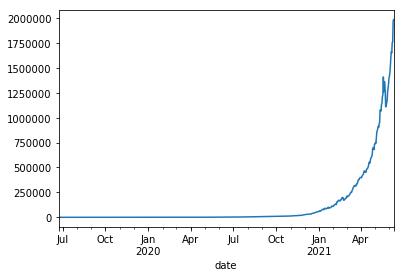

In [291]:
# Calculate cumulative return of model and plot the result
(1 + (results['returns'] * results['Predicted Value'])).cumprod().plot()

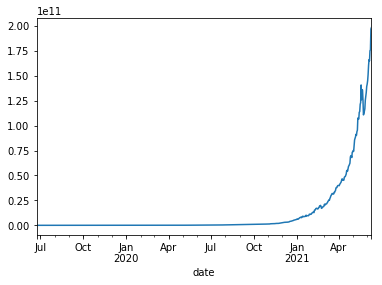

In [292]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (results['returns'] * results['Predicted Value'])).cumprod()
cumulative_return_capital.plot()

In [293]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

acc_score = accuracy_score(y_test, predictions)

In [294]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,258,83
Actual 1,80,298


Accuracy Score : 0.7732962447844228
Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       341
         1.0       0.78      0.79      0.79       378

    accuracy                           0.77       719
   macro avg       0.77      0.77      0.77       719
weighted avg       0.77      0.77      0.77       719



In [295]:
#model = load('random_forest_model.joblib')
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [296]:
#Load the model
model = load('random_forest_model.joblib')
predictions = model.predict(X_test)
predictions

array([0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0.

# Backtest the SMA Moving Average Trading Strategy:

In [276]:
signals_df = generate_signals(btc)

In [277]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 10

# Take a 10 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals_df['Position'] = share_size * signals_df['Signal']

# Find the points in time where a 10 share position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

# Calculate the cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
signals_df.head(5)

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
date,,,,,,,,,,,,,,,,,
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,NaN,NaN
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2019-06-26,12933.7,12684.3,25637.82859518,100171,0.099328,1,NaN,NaN,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2019-06-27,11148.0,11581.1,25035.66966057,90274,-0.138066,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0


In [278]:
# Visualize exit position relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [279]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [280]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    signals_df['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    signals_df['Portfolio Daily Returns'].mean() * 252) / (
    signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
portfolio_evaluation_df

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

,Backtest
Annual Return,0.610271
Cumulative Returns,2.42755
Annual Volatility,0.58654
Sharpe Ratio,1.040458
Sortino Ratio,1.532578


In [281]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Crypto', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

,Crypto,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [282]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in signals_df.iterrows():
    if row['Entry/Exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['close']

    elif row['Entry/Exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
        exit_share_price = row['close']
        profit_loss =  exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Crypto': 'BTC',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

,Crypto,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,BTC,2020-02-04,2020-03-28,10.0,9159.3,6251.8,91593.0,62518.0,-29075.0
1,BTC,2020-05-20,2020-10-18,10.0,9510.1,11508.9,95101.0,115089.0,19988.0
2,BTC,2020-10-27,2021-05-24,10.0,13649.6,38833.8,136496.0,388338.0,251842.0


In [283]:
price_df = signals_df[['close', 'SMA50', 'SMA100']]
price_chart = price_df.hvplot.line()
price_chart.opts(xaxis=None)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [284]:
portfolio_evaluation_df.reset_index(inplace=True)
portfolio_evaluation_table = portfolio_evaluation_df.hvplot.table()
portfolio_evaluation_table

:Table   [index,Backtest]

In [285]:
trade_evaluation_table = trade_evaluation_df.hvplot.table()
trade_evaluation_table

:Table   [Crypto,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]

In [286]:
# Assemble dashboard visualization
display(Markdown("# Trading Dashboard"))
display(price_chart)
portfolio_evaluation_table + trade_evaluation_table

# Trading Dashboard

:NdOverlay   [Variable]
   :Curve   [date]   (value)

:Layout
   .Table.I  :Table   [index,Backtest]
   .Table.II :Table   [Crypto,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]